In [111]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Assignment: Solving the Cliff Walking Problem Using Q-Learning
Objective:
The goal of this assignment is to:
•	Implement the Q-Learning algorithm for solving the Cliff Walking environment in OpenAI Gym.
•	Understand the impact of hyperparameters like learning rate (α), discount factor (γ), and exploration (ϵ).
Environment Description:
The Cliff Walking environment is a grid-world problem:
•	The agent starts at the top-left corner.
•	The goal is to reach the bottom-right corner.
•	The bottom row has a "cliff" region: stepping into the cliff resets the agent to the start with a reward of -100.
•	Normal steps have a reward of -1.

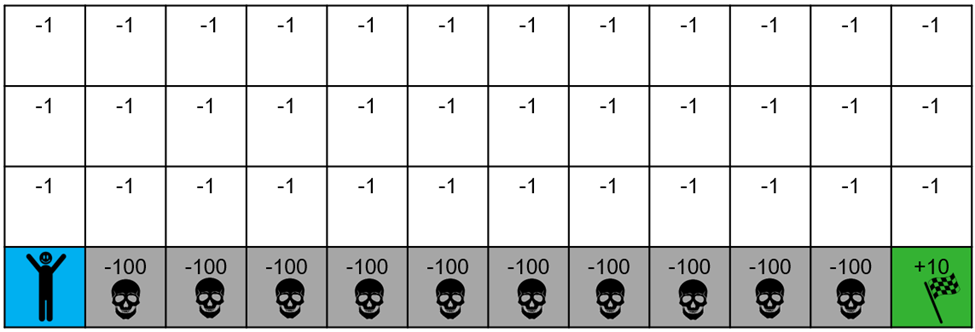


# Description
The game starts with the player at location [3, 0] of the 4x12 grid world with the goal located at [3, 11]. If the player reaches the goal the episode ends.

A cliff runs along [3, 1..10]. If the player moves to a cliff location it returns to the start location.

The player makes moves until they reach the goal.

Adapted from Example 6.6 (page 132) from Reinforcement Learning: An Introduction by Sutton and Barto [1].

The cliff can be chosen to be slippery (disabled by default) so the player may move perpendicular to the intended direction sometimes (see is_slippery).

With inspiration from: https://github.com/dennybritz/reinforcement-learning/blob/master/lib/envs/cliff_walking.py

https://gymnasium.farama.org/_images/cliff_walking.gif
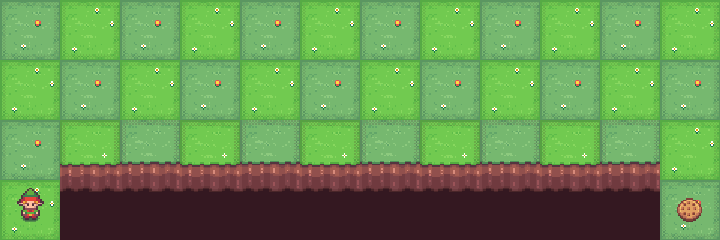
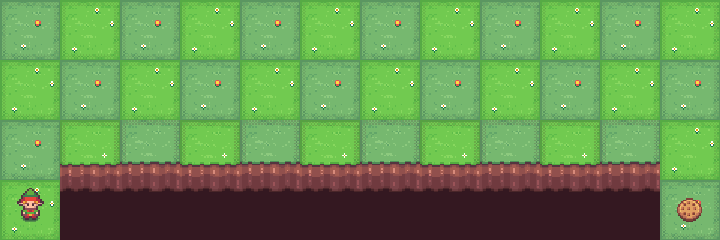

In [112]:
import numpy as np
import pandas as pd
import gym
import random
import os
import gymnasium as gym



In [113]:
import warnings
warnings.filterwarnings("ignore")

## Step 1: Create and understand cliff walking environment¶


In [114]:
env = gym.make("CliffWalking-v0")

In [115]:
env.reset() # This resets the environment to its initial state.

(36, {'prob': 1})

In [116]:
print('\n ____Action Space____ \n')
print('Action Space Shape: ', env.action_space.n)
print('Action Space Sample: ', env.action_space.sample())


 ____Action Space____ 

Action Space Shape:  4
Action Space Sample:  0


In [117]:
state_space = env.observation_space.n
print(f'There are {state_space} possible states. \n')
action_space = env.action_space.n
print(f'There are {action_space} possible actions. \n')

There are 48 possible states. 

There are 4 possible actions. 



## Step 2: Create and Initialize the Q-table¶

In [118]:
# lets create QTable of size(state_space, action_space) & Initialize each value at 0 using np.zeros

def initialize_q_table(state_space, action_space):
    qTable = np.zeros((state_space, action_space))

    return qTable 

In [119]:
qTable_cliffwalking = initialize_q_table(state_space, action_space)

In [120]:
qTable_cliffwalking

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],


## step 3: Define Epsilon Greedy Policy (Acting Policy)

In [121]:
def epsilon_greedy_policy(qTable, state, epsilon):
    # Choose a random number between 0 and 1
    random_num = random.uniform(0, 1)

    if random_num > epsilon:
        # Exploitation: choose the best action
        action = np.argmax(qTable[state])
    else:
        # Exploration: choose a random action
        action = env.action_space.sample()

    return action

## Step 4: Define the Greedy Policy (Updating Policy)¶

In [122]:
def greedy_policy(qTable, state):
    action = np.argmax(qTable[state])

    return action

## Step 5: Define Hyperparameters¶

In [123]:
# Training parameters
n_training_episodes = 10000  # Total training episodes
learning_rate = 0.7          # Learning rate

# Evaluation parameters
n_eval_episodes = 100        # Total number of test episodes

# Environment parameters
env_id = "CliffWalking-v0"   # Name of the environment
max_steps = 99               # Max steps per episode
gamma = 0.95                 # Discounting rate # This is the discounting rate, which determines the importance of future rewards. A value close to 1 means future rewards are highly considered, while a value close to 0 means the agent prioritizes immediate rewards.
eval_seed = []               # The evaluation seed of the environment

# Exploration parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.05            # Minimum exploration probability
decay_rate = 0.0005            # Exponential decay rate for exploration prob

## Step 6: Create Trainig Loop Method


In [124]:
def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, qTable):
    episode_rewards = []

    for episode in range(n_training_episodes):
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)

        state = env.reset()
        if isinstance(state, tuple):  # Gym v0.26+
            state = state[0]

        done = False
        total_reward = 0

        for step in range(max_steps):
            action = epsilon_greedy_policy(qTable, state, epsilon)

            result = env.step(action)
            if len(result) == 5:
                new_state, reward, terminated, truncated, info = result
                done = terminated or truncated
            else:
                new_state, reward, done, info = result

            if isinstance(new_state, tuple):
                new_state = new_state[0]

            # ✅ Extra Safety Check
            if not (0 <= state < qTable.shape[0]) or not (0 <= action < qTable.shape[1]):
                raise ValueError(f"Invalid index: state={state}, action={action}")

            # Q-learning update
            qTable[state][action] += learning_rate * (
                reward + gamma * np.max(qTable[new_state]) - qTable[state][action]
            )

            state = new_state
            total_reward += reward

            if done:
                break

        episode_rewards.append(total_reward)

    return qTable, episode_rewards


## Step 7: Train the The Q-Learning Agent

In [125]:
# Training and reward tracking
qTable_cliffwalking, episode_rewards = train(
    n_training_episodes, min_epsilon, max_epsilon, decay_rate,
    env, max_steps, qTable_cliffwalking
)


## Step 8: Let's see the Q-Learning Table

In [126]:
qTable_cliffwalking

array([[ -10.7341754 ,  -10.24650042,  -10.24650042,  -10.7341754 ],
       [ -10.24650042,   -9.73315833,   -9.73315833,  -10.7341754 ],
       [  -9.73315833,   -9.19279825,   -9.19279825,  -10.24650042],
       [  -9.19279825,   -8.62399815,   -8.62399815,   -9.73315833],
       [  -8.62399815,   -8.02526122,   -8.02526122,   -9.19279825],
       [  -8.02526122,   -7.39501181,   -7.39501181,   -8.62399815],
       [  -7.39501181,   -6.73159137,   -6.73159137,   -8.02526122],
       [  -6.73159137,   -6.03325408,   -6.03325408,   -7.39501181],
       [  -6.03325408,   -5.29816219,   -5.29816219,   -6.73159137],
       [  -5.29816219,   -4.52438125,   -4.52438125,   -6.03325408],
       [  -4.52438125,   -3.709875  ,   -3.709875  ,   -5.29816219],
       [  -3.709875  ,   -3.709875  ,   -2.8525    ,   -4.52438125],
       [ -10.7341754 ,   -9.73315833,   -9.73315833,  -10.24650042],
       [ -10.24650042,   -9.19279825,   -9.19279825,  -10.24650042],
       [  -9.73315833,   -8.623998

## Step 9: Define the Evaluation Method


In [127]:
def evaluate_agent(env, qTable, n_eval_episodes, max_steps):
    rewards_per_episode = []

    for episode in range(n_eval_episodes):
        state = env.reset()
        if isinstance(state, tuple):  # Gym v0.26+ returns (obs, info)
            state = state[0]

        done = False
        episode_reward = 0

        for step in range(max_steps):
            action = np.argmax(qTable[state])  # Always exploit (greedy)

            result = env.step(action)
            if len(result) == 5:
                new_state, reward, terminated, truncated, info = result
                done = terminated or truncated
            else:
                new_state, reward, done, info = result

            if isinstance(new_state, tuple):  # Gym v0.26+
                new_state = new_state[0]

            episode_reward += reward
            state = new_state

            if done:
                break

        rewards_per_episode.append(episode_reward)

    # calculate avg reward and standard deviation
    avg_reward = np.mean(rewards_per_episode)
    std_reward = np.std(rewards_per_episode)

    return avg_reward, std_reward


## Step 10: Evaluate our Q-Learning Agent¶


In [128]:
mean_reward, std_reward = evaluate_agent(env, qTable_cliffwalking, n_eval_episodes, max_steps) 
print(f"Mean Reward: {mean_reward:.2f} ± {std_reward:.2f}")


Mean Reward: -13.00 ± 0.00


# Visualize Optimal Policy with Arrows on the Grid

In [129]:
def display_optimal_policy(qTable, env_shape=(4, 12)):
    # Map action indices to symbols: 0=↑, 1=→, 2=↓, 3=←
    action_symbols = ['↑', '→', '↓', '←']
    policy_grid = []

    # Loop through each state in the environment
    for state in range(env.observation_space.n):
        if state == 47:  # Goal state (bottom-right corner in CliffWalking)
            policy_grid.append('G')
        elif state in range(37, 47):  # Cliff cells (bottom row excluding start/goal)
            policy_grid.append('C')
        else:
            # Choose the best action (greedy) from the Q-table
            best_action = np.argmax(qTable[state])
            policy_grid.append(action_symbols[best_action])

    # Reshape the flat policy list into a 2D grid
    policy_grid = np.array(policy_grid).reshape(env_shape)

    # Print the policy grid
    print("\nOptimal Policy Grid:\n")
    for row in policy_grid:
        print(' '.join(row))


# Visualize learned policy
display_optimal_policy(qTable_cliffwalking)



Optimal Policy Grid:

→ → → → → → → → → → → ↓
→ → → → → → → → → → → ↓
→ → → → → → → → → → → ↓
↑ C C C C C C C C C C G


# Plot Training Rewards 

In [130]:
import matplotlib.pyplot as plt

def plot_rewards(rewards):
    # Create a figure and plot the reward values
    plt.figure(figsize=(12, 5))  # Set figure size
    plt.plot(rewards, label='Reward per Episode')  # Plot rewards per episode
    plt.xlabel("Episode")  # Label for x-axis
    plt.ylabel("Total Reward")  # Label for y-axis
    plt.title("Training Progress: Rewards over Episodes")  # Chart title
    plt.legend()  # Add legend
    plt.grid()  # Add grid lines for better readability
    plt.show()  # Display the plot


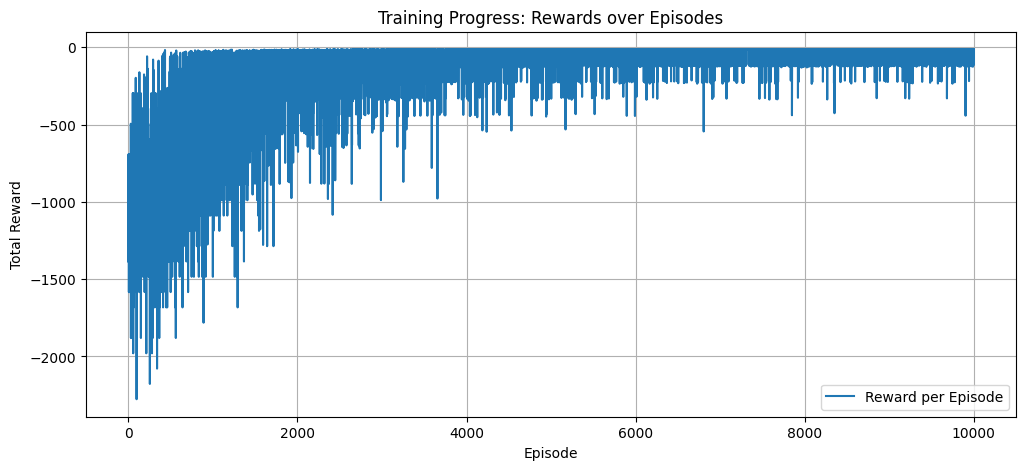

In [131]:
plot_rewards(episode_rewards)


# 🏃 Render Agent Movement (Step by Step):

In [132]:
import time
import os
from IPython.display import clear_output  # For Jupyter

def run_agent_greedy(env, qTable, max_steps=99, sleep_time=0.3):
    state = env.reset()
    if isinstance(state, tuple):  # Gym v0.26+
        state = state[0]

    total_reward = 0
    done = False

    print("🚶 Agent starting...\n")

    for step in range(max_steps):
        # Clear previous frame (for Jupyter or CLI)
        clear_output(wait=True)  # If in Jupyter
        # os.system('cls' if os.name == 'nt' else 'clear')  # If in terminal

        env.render()  # Print the environment
        print(f"\nStep: {step}")
        
        action = greedy_policy(qTable, state)
        result = env.step(action)

        if len(result) == 5:  # Gym v0.26+
            new_state, reward, terminated, truncated, info = result
            done = terminated or truncated
        else:
            new_state, reward, done, info = result

        if isinstance(new_state, tuple):
            new_state = new_state[0]

        total_reward += reward
        state = new_state

        time.sleep(sleep_time)  # Delay to visualize step-by-step

        if done:
            clear_output(wait=True)
            env.render()
            print(f"\nFinished after {step + 1} steps with total reward: {total_reward}")
            break

    if not done:
        print(f"\nAgent didn't reach the goal within {max_steps} steps. Total reward: {total_reward}")


run_agent_greedy(env, qTable_cliffwalking, max_steps=99, sleep_time=0.3)


Finished after 13 steps with total reward: -13
